### 1. Derive the ridge regression formula shown above. You may find some of the linear algebra tricks we saw in the [matrix cookbook](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf) helpful here.

\begin{align*}
\frac{\partial \mathcal{L}}{\partial \theta} &= \frac{\partial}{\partial \theta} \left\{ (\mathbf{X} \theta - \mathbf{y})^T(\mathbf{X}\theta - \mathbf{y}) + \lambda \theta^T \theta \right\} \\
&= \mathbf{X}^T ( \mathbf{X} \theta - \mathbf{y}) + 2 \lambda \theta ~~~~~~~~~~~~~~~~~~~~~~~~ \text{Via one of the identities in the matrix cookbook}\\
\implies \mathbf{X}^T \mathbf{y} &= \mathbf{X}^T \mathbf{X} \theta - 2 \lambda \theta ~~~~~~~~~~~~~~~~~~~~~~~~\text{Setting the gradient equal to zero} \\
\implies \theta &= (\mathbf{X}^T \mathbf{X} + \lambda I)^{-1} \mathbf{X}^T \mathbf{y} 
\end{align*}

### 2. Implement a Ridge Regression model and predict the next values of the Navier-Stokes equations. You should download the [von Karman dataset](https://utexas.box.com/s/44f89zfy7v2k4g5wq4kv3vfvkm9w91wm) and place it in the top-level directory `cphy/resources/`. I've included an object below that will handle creating train/val/test splits for you, and I've also included placeholder code to get you started on the regression model. For now, just implement the "global" solution method to the ridge regression problem. You can implement an iterative solution if you want to try something harder.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Velocity field data has shape: (375, 64, 32, 2)


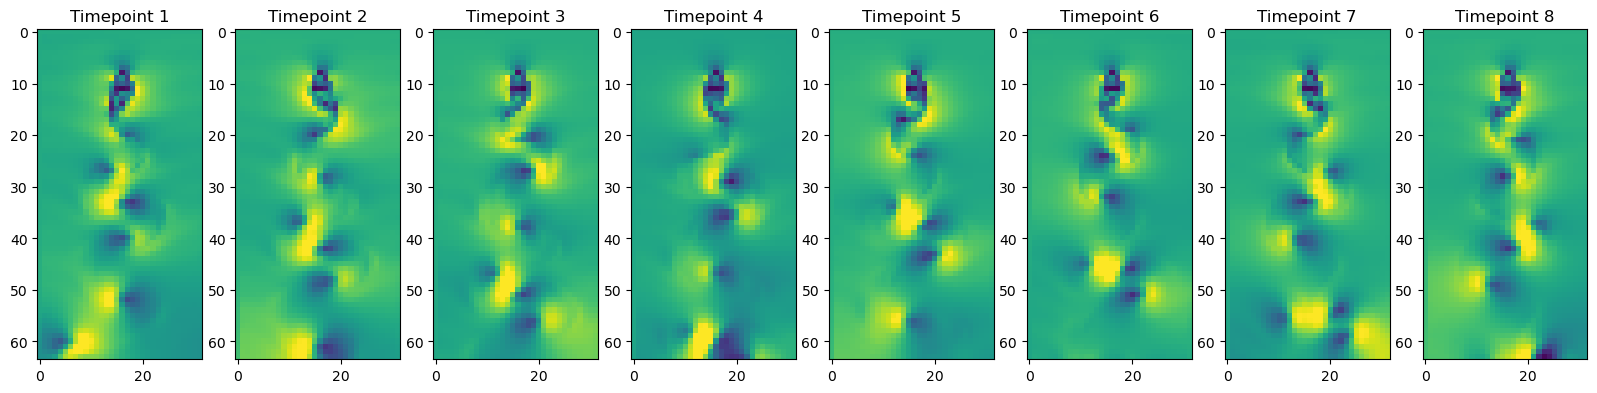

In [2]:
## Load the velocity field data

Re = 600 # Reynolds number, change this to 300, 600, 900, 1200

# Load the two-dimensional velocity field data. Data is stored in a 4D numpy array,
# where the first dimension is the time index, the second and third dimensions are the
# x and y coordinates, and the fourth dimension is the velocity components (ux or uv).
vfield = np.load(
    f"/Users/swilliamson/Documents/GitHub/comp_physics_sw/hw/resources/vortex_street_data/vortex_street_velocities_Re_{Re}_largefile.npz", 
    allow_pickle=True
)
# downsample the data for faster training
vfield = vfield[::8, ::4, ::4]
print("Velocity field data has shape: {}".format(vfield.shape))

# Compute the velocity magnitude
vfield_mag = np.sqrt(vfield[..., 0]**2 + vfield[..., 1]**2)

n_tpts = vfield.shape[0]
plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(1, 8, i+1)
    v_vals = vfield_mag[n_tpts // 8 * i]
    plt.imshow(v_vals, cmap="viridis", vmin=0, vmax=np.percentile(v_vals, 99))
    plt.title("Timepoint {}".format(i + 1))

In [7]:
class ForecastingDataset:
    """
    A class for formatting time series data for forecasting.
    By convention, time is assumed to be the first dimension of the dataset.

    For time series data, it is very important that all data in test set is after 
    all data in the train and val sets. We also need to ensure that datapoints don't
    appear in multiple splits. 

    Parameters
        X (np.ndarray): The time series data. The first dimension is assumed to be time.
        split_ratio (tuple): The ratio of the data to be used for train, val, and test.
        forecast_horizon (int): The number of time steps to forecast at once
        featurizer (callable): A function that takes in multivariate snapshot and 
            returns a feature vector. If None, the raw data is used.
    """

    def __init__(self, X, split_ratio=(0.6, 0.2, 0.2), forecast_horizon=1, featurizer=None):

        if featurizer is None:
            self.featurizer = lambda x: x
        else:
            self.featurizer = featurizer

        self.feature_shape = X.shape[1:]

        # We need to ensure that datapoints don't appear in multiple splits, hence why
        # we crop by the forecast horizon. We are going to do one-step forecasting
        self.X_full = self.featurizer(X[:-1])#[:-forecast_horizon]
        self.y_full = X[1:]#[forecast_horizon:]
        self.forecast_horizon = forecast_horizon

        # Split the data into train, val, test
        n_train = int(len(self.X_full) * split_ratio[0])
        n_val = int(len(self.X_full) * split_ratio[1])
        n_test = len(self.X_full) - n_train - n_val

        # Our frequent use of the forecast_horizon parameter again arises from our need
        # to ensure that datapoints don't appear in multiple splits.
        self.X_train, self.y_train = self.X_full[:n_train], self.y_full[:n_train]
        self.X_val, self.y_val = (
            self.X_full[n_train + forecast_horizon : n_train + forecast_horizon + n_val], 
            self.y_full[n_train+ forecast_horizon : n_train + forecast_horizon + n_val]
        )
        self.X_test, self.y_test = (
            self.X_full[n_train + 2 * forecast_horizon+ n_val:], 
            self.y_full[n_train + 2 * forecast_horizon + n_val:]
        )

    def __len__(self):
        return len(self.X_full)

    def __getitem__(self, idx):
        return self.X_full[idx], self.y_full[idx]

    def flatten_data(self, x):
        """
        Given a dataset, transform into a flat feature form
        """
        return np.reshape(x, (x.shape[0], -1))

    def unflatten_data(self, x):
        """
        Given a flat dataset, convert back to the original shape
        """
        out = np.reshape(x, (x.shape[0], *self.feature_shape))
        return out



# Let's do a simple unit test to make sure that our class is working as expected
# Take some time to understand what these test cases cover
import unittest
class TestForecastingDataset(unittest.TestCase):
    def test_initialization(self):
        fd = ForecastingDataset(np.arange(100)[:, None])
        assert fd.y_train[0] == fd.X_train[1], "y_train is not shifted by 1 from X_train"
        assert fd.y_val[0] == fd.X_val[1], "y_val is not shifted by 1 from X_val"
        assert fd.y_test[0] == fd.X_test[1], "y_test is not shifted by 1 from X_test"
        
        assert fd.y_train[-1] < fd.y_val[0], "y_train and y_test are not disjoint"
        assert fd.y_val[-1] < fd.y_test[0], "y_val and y_test are not disjoint"

unittest.main(argv=[''], exit=False);

.
----------------------------------------------------------------------
Ran 1 test in 0.000s

OK


In [8]:
import warnings

class BaseRegressor:
    """
    A base class for regression models.
    """
    def __init__(self):
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        """
        Fits the model to the data.
        """
        raise NotImplementedError("Subclasses must implement this method")

    def predict(self, X):
        return X @ self.weights + self.bias

    def score(self, X, y):
        """
        Returns the mean squared error of the model.
        """
        return np.mean((self.predict(X) - y)**2)


class LinearRegressor(BaseRegressor):
    """
    A linear regression model is a linear function of the form:
    y = w0 + w1 * x1 + w2 * x2 + ... + wn * xn

    The weights are the coefficients of the linear function.
    The bias is the constant term w0 of the linear function.

    Attributes:
        method: str, optional. The method to use for fitting the model.
        regularization: str, optional. The type of regularization to use.
    """
    
    def __init__(self, method="global", regularization="ridge", regstrength=0.1, **kwargs):
        super().__init__(**kwargs)
        self.method = method
        self.regularization = regularization
        self.regstrength = regstrength

    # functions that begin with underscores are private, by convention.
    # Technically we could access them from outside the class, but we should
    # not do that because they can be changed or removed at any time.
    def _fit_global(self, X, y):
        """
        Fits the model using the global least squares method.
        """
        
        self.weights = np.linalg.inv( np.transpose(X) @ X + np.eye(X.shape[1]) * self.regstrength ) @ np.transpose(X) @ y
        self.bias = np.mean(y - X @ self.weights)

        return self.weights, self.bias

    def _fit_iterative(self, X, y, learning_rate=0.01):
        """
        Fit the model using gradient descent.
        """
        ############################################################
        #
        #
        # YOUR CODE HERE
        #
        #
        ############################################################
        raise NotImplementedError

    def fit(self, X, y):
        """
        Fits the model to the data. The method used is determined by the
        `method` attribute.
        """

        ans = self._fit_global(X, y)

        return ans


Text(0.5, 0, 'Time step')

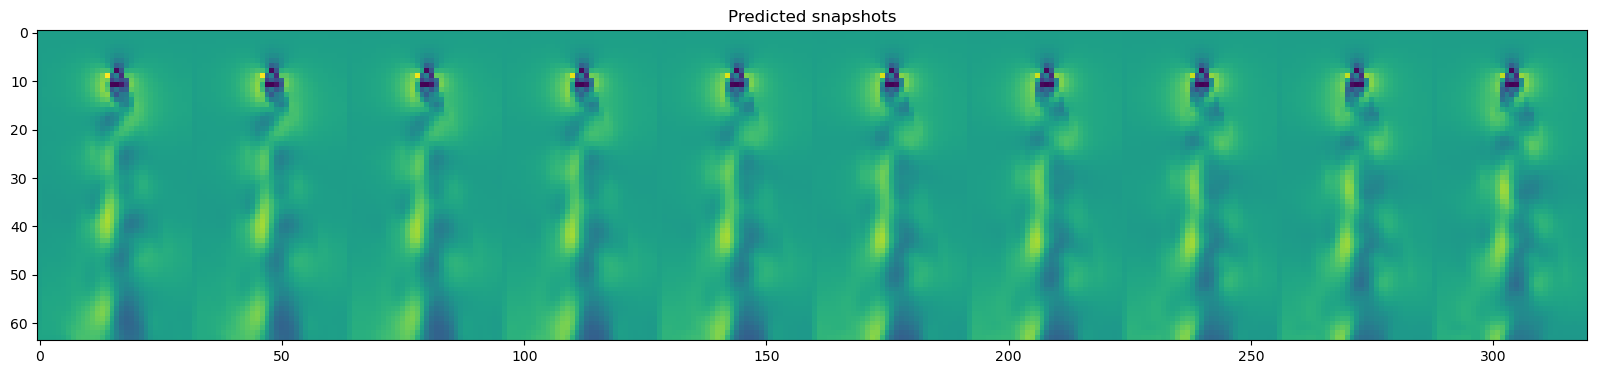

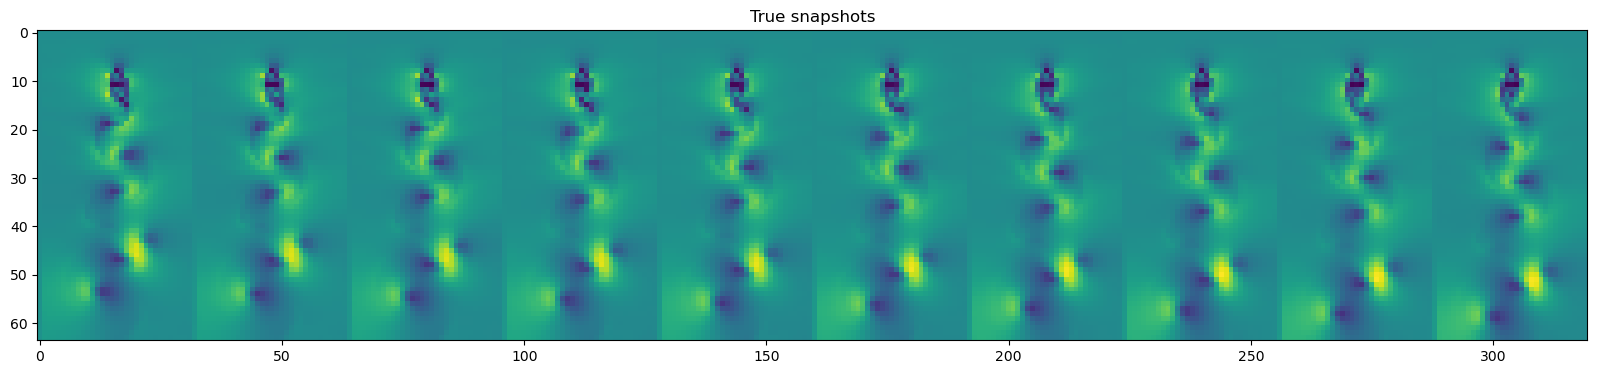

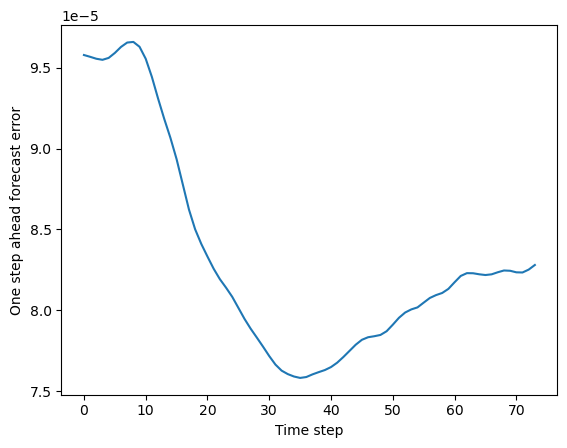

In [9]:
# Automatically split the data into train, validation, and test sets
dataset= ForecastingDataset(vfield_mag)

# Initialize the model
model = LinearRegressor(method="global", regularization="ridge", regstrength=1.0)

model.fit(
    dataset.flatten_data(dataset.X_train), 
    dataset.flatten_data(dataset.y_train)
)

y_test_pred = dataset.unflatten_data(
    model.predict(dataset.flatten_data(dataset.X_test))
)

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(y_test_pred[::3][-10:]))
plt.title("Predicted snapshots")

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(dataset.y_test[::3][-10:]))
plt.title("True snapshots")


mse_vs_time = np.mean((y_test_pred - dataset.y_test)**2, axis=(1, 2))
plt.figure()
plt.plot(mse_vs_time)
plt.ylabel("One step ahead forecast error")
plt.xlabel("Time step")

### 3. You'll notice that my train/test split in the ForecastingDataset object ensures that the test data occurs after the training data in the time series, and that no data points are repeated. Why do you think this is important for this problem?


In general we saw in class that you want to keep test and train completely separate. If we train on data that we're going to use for testing then we're sort of guaranteeing that we get a "good" result when we go to test our network, but it's a false positive. We only get a good result because we've seen the information before. 

### 4. Our model has a single hyperparameter, the regularizer strength $\lambda$, that determines the degree to which the weight entries in the regression matrix are penalized. Using the validation fold of our training dataset, find the best value of that hyperparameter.


In [10]:
regstrengths = np.logspace(-4, 4, 9)

all_mse = []
for regstrength in regstrengths:
    print(f"Training model with regstrength={regstrength}", flush=True)

    model = LinearRegressor(method="global", regularization="ridge", regstrength=regstrength)

    model.fit(
        dataset.flatten_data(dataset.X_train), 
        dataset.flatten_data(dataset.y_train)
    )

    y_val_pred = dataset.unflatten_data(
        model.predict(dataset.flatten_data(dataset.X_val))
    )

    mse = np.mean((y_val_pred - dataset.y_val)**2)
    all_mse.append(mse)

best_regstrength = regstrengths[np.argmin(np.array(all_mse))]

print(f"Best regularize strength: {best_regstrength}")

Training model with regstrength=0.0001
Training model with regstrength=0.001
Training model with regstrength=0.01
Training model with regstrength=0.1
Training model with regstrength=1.0
Training model with regstrength=10.0
Training model with regstrength=100.0
Training model with regstrength=1000.0
Training model with regstrength=10000.0
Best regularize strength: 0.0001


### 5. Repeat your experiments using datasets with different Reynolds numbers. How does forecast accuracy generally change with Reynolds number?


Creating a function that allows us to pick the Reynolds number 

In [12]:
## Load the velocity field data

def choose_Reynolds(re):
    Re = re # Reynolds number, change this to 300, 600, 900, 1200

    # Load the two-dimensional velocity field data. Data is stored in a 4D numpy array,
    # where the first dimension is the time index, the second and third dimensions are the
    # x and y coordinates, and the fourth dimension is the velocity components (ux or uv).
    vfield = np.load(
        f"/Users/swilliamson/Documents/GitHub/comp_physics_sw/hw/resources/vortex_street_data/vortex_street_velocities_Re_{Re}_largefile.npz", 
        allow_pickle=True
    )
    # downsample the data for faster training
    vfield = vfield[::8, ::4, ::4]
    print("Velocity field data has shape: {}".format(vfield.shape))

    # Compute the velocity magnitude
    vfield_mag = np.sqrt(vfield[..., 0]**2 + vfield[..., 1]**2)

    return vfield_mag 


Now just trying the model with different options for Reynold's numbers:

Velocity field data has shape: (375, 64, 32, 2)


Text(0.5, 1.0, 'True snapshots: Re = 300')

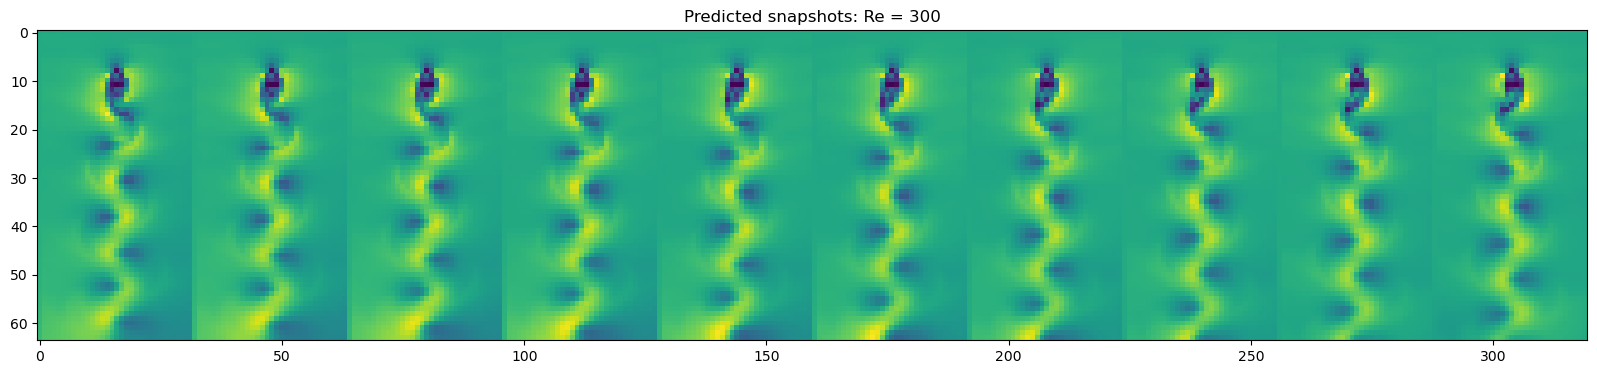

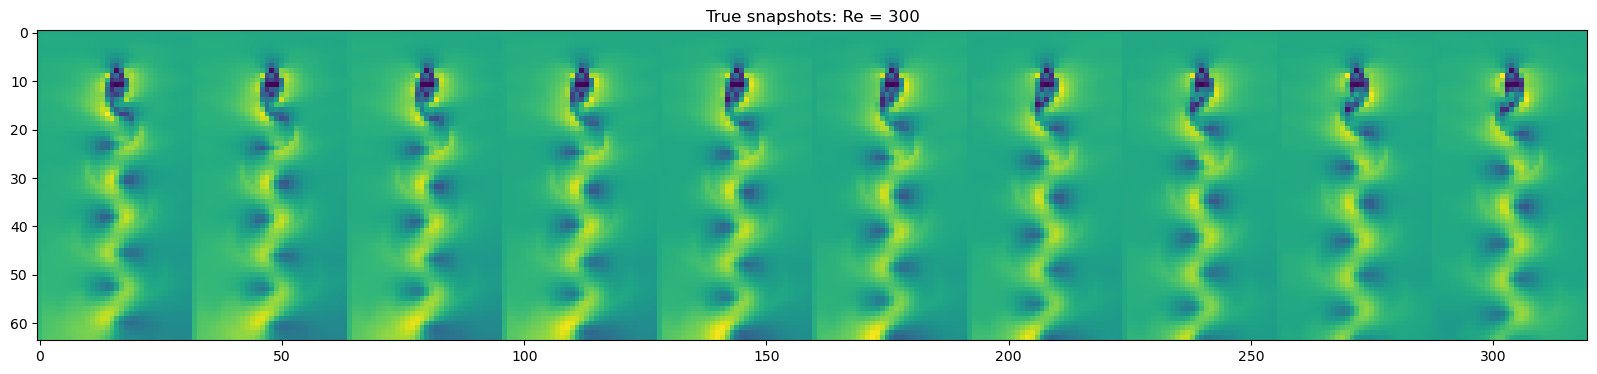

In [20]:
# Automatically split the data into train, validation, and test sets

re = 300
vfield_mag = choose_Reynolds(re)
dataset= ForecastingDataset(vfield_mag)

# Initialize the model
model = LinearRegressor(method="global", regularization="ridge", regstrength=0.0001)

model.fit(
    dataset.flatten_data(dataset.X_train), 
    dataset.flatten_data(dataset.y_train)
)

y_test_pred = dataset.unflatten_data(
    model.predict(dataset.flatten_data(dataset.X_test))
)

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(y_test_pred[::3][-10:]))
plt.title("Predicted snapshots: Re = {}".format(re))

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(dataset.y_test[::3][-10:]))
plt.title("True snapshots: Re = {}".format(re))

Velocity field data has shape: (375, 64, 32, 2)


Text(0.5, 1.0, 'True snapshots: Re = 600')

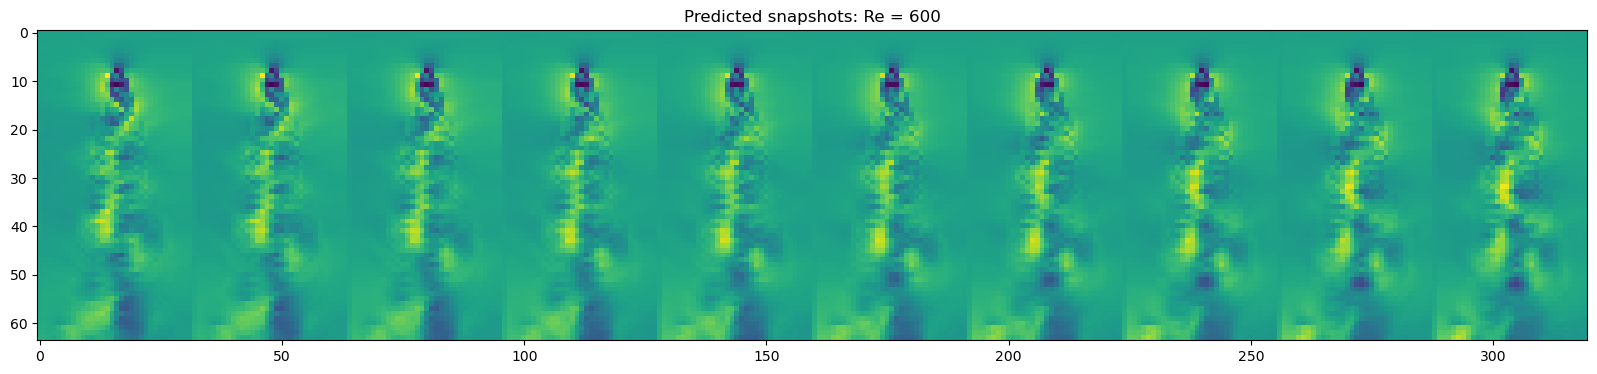

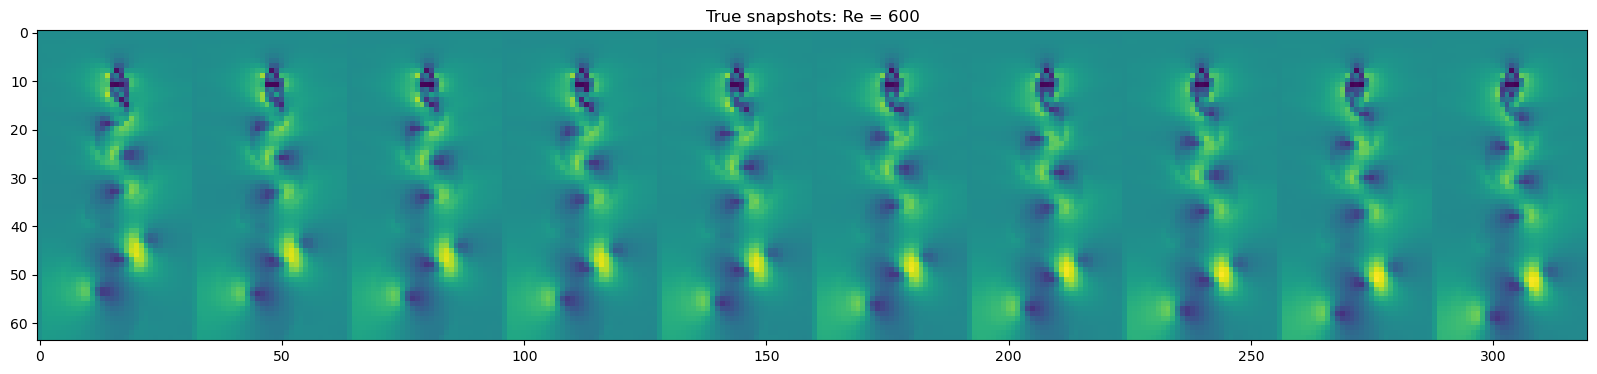

In [19]:
# Automatically split the data into train, validation, and test sets

re = 600
vfield_mag = choose_Reynolds(re)
dataset= ForecastingDataset(vfield_mag)

# Initialize the model
model = LinearRegressor(method="global", regularization="ridge", regstrength=0.0001)

model.fit(
    dataset.flatten_data(dataset.X_train), 
    dataset.flatten_data(dataset.y_train)
)

y_test_pred = dataset.unflatten_data(
    model.predict(dataset.flatten_data(dataset.X_test))
)

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(y_test_pred[::3][-10:]))
plt.title("Predicted snapshots: Re = {}".format(re))

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(dataset.y_test[::3][-10:]))
plt.title("True snapshots: Re = {}".format(re))

Velocity field data has shape: (375, 64, 32, 2)


Text(0.5, 1.0, 'True snapshots: Re = 900')

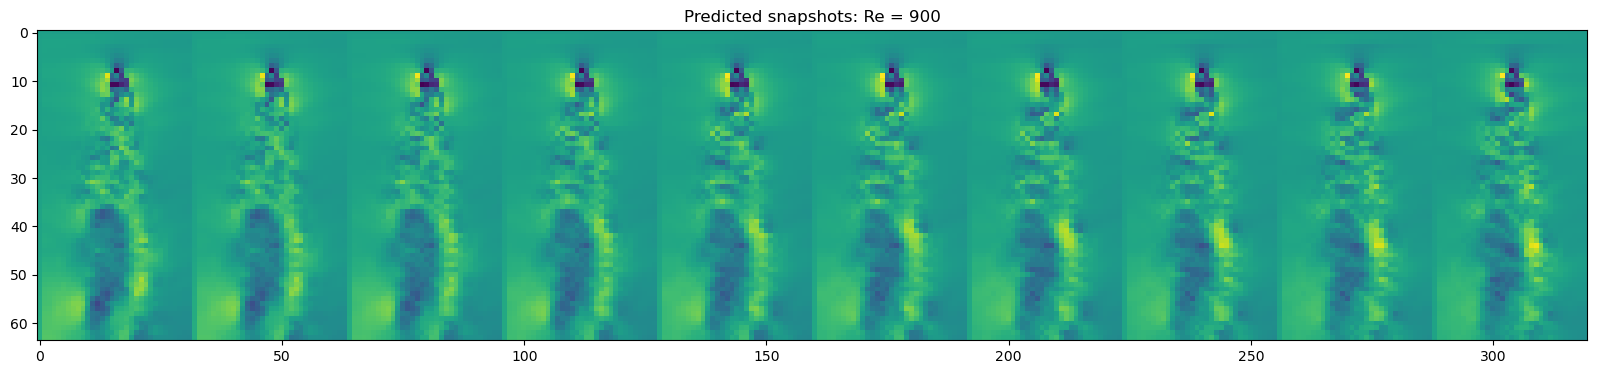

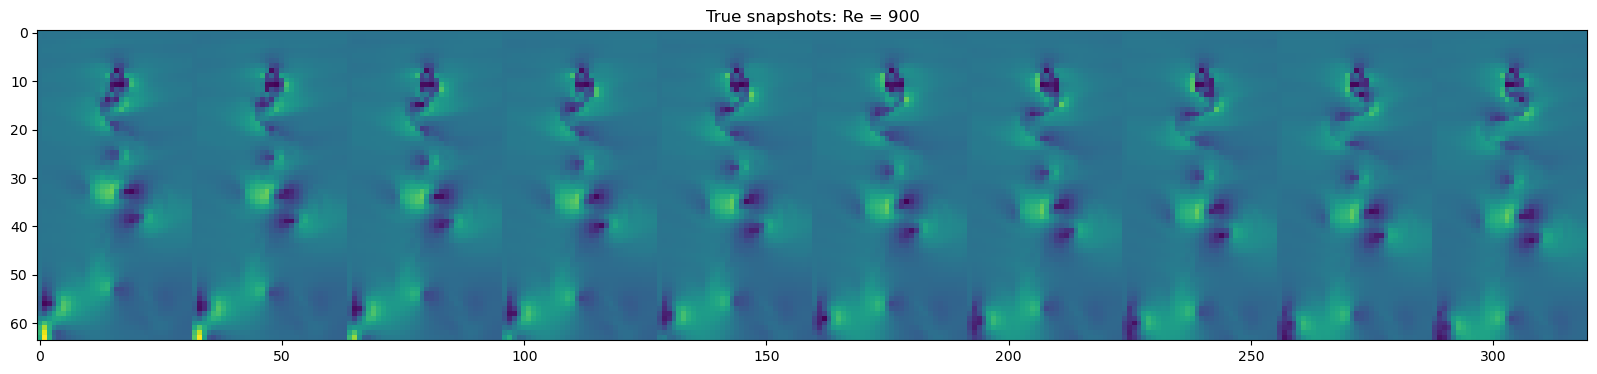

In [18]:
# Automatically split the data into train, validation, and test sets

re = 900
vfield_mag = choose_Reynolds(re)
dataset= ForecastingDataset(vfield_mag)

# Initialize the model
model = LinearRegressor(method="global", regularization="ridge", regstrength=0.0001)

model.fit(
    dataset.flatten_data(dataset.X_train), 
    dataset.flatten_data(dataset.y_train)
)

y_test_pred = dataset.unflatten_data(
    model.predict(dataset.flatten_data(dataset.X_test))
)

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(y_test_pred[::3][-10:]))
plt.title("Predicted snapshots: Re = {}".format(re))

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(dataset.y_test[::3][-10:]))
plt.title("True snapshots: Re = {}".format(re))

Velocity field data has shape: (375, 64, 32, 2)


Text(0.5, 1.0, 'True snapshots: Re = 1200')

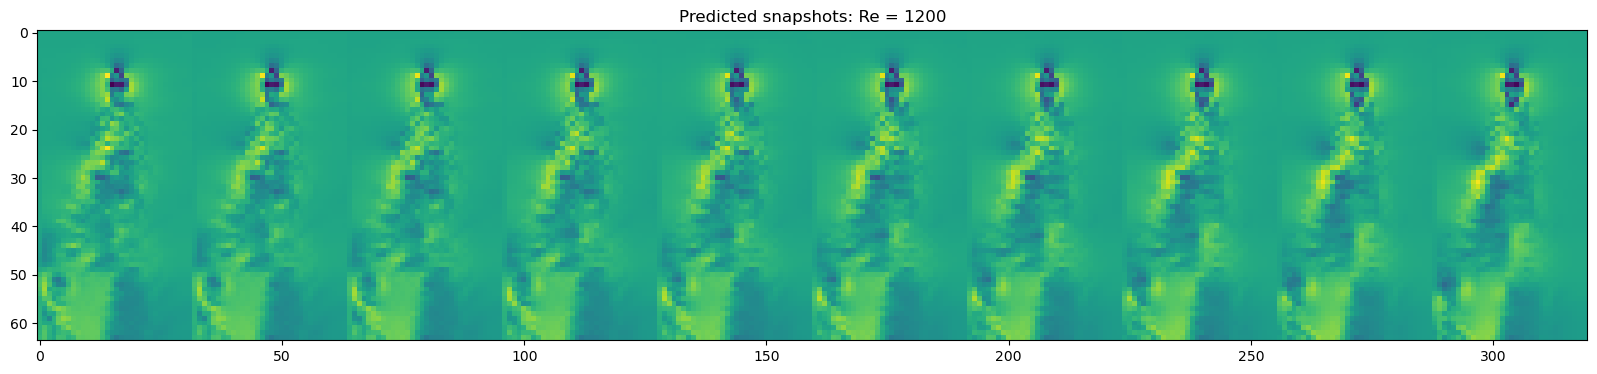

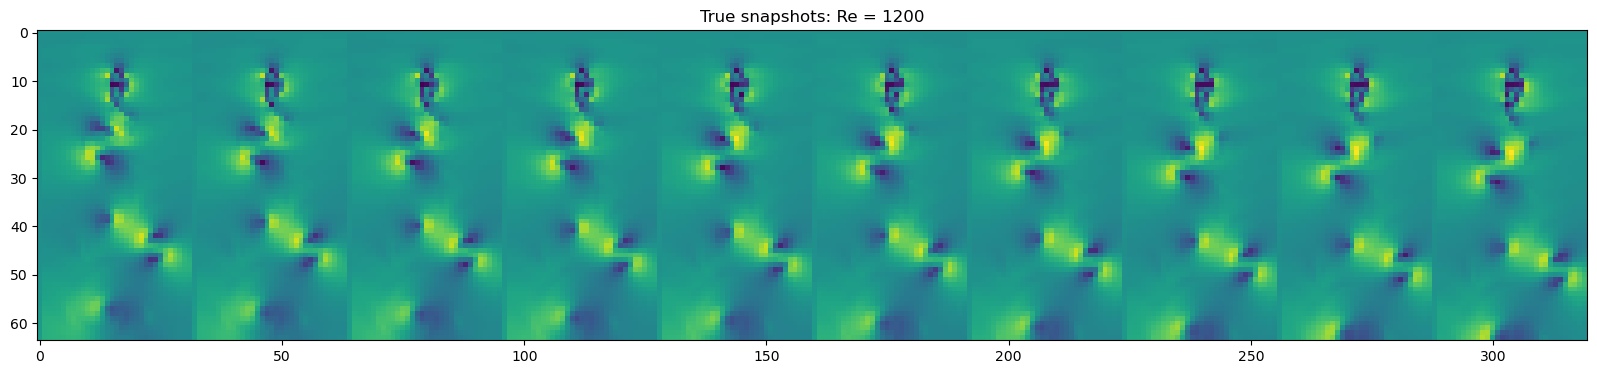

In [17]:
# Automatically split the data into train, validation, and test sets

re = 1200
vfield_mag = choose_Reynolds(re)
dataset= ForecastingDataset(vfield_mag)

# Initialize the model
model = LinearRegressor(method="global", regularization="ridge", regstrength=0.0001)

model.fit(
    dataset.flatten_data(dataset.X_train), 
    dataset.flatten_data(dataset.y_train)
)

y_test_pred = dataset.unflatten_data(
    model.predict(dataset.flatten_data(dataset.X_test))
)

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(y_test_pred[::3][-10:]))
plt.title("Predicted snapshots: Re = {}".format(re))

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(dataset.y_test[::3][-10:]))
plt.title("True snapshots: Re = {}".format(re))

Sort of expected, as we took the Reynold's number larger (and thus created flow that was more chaotic and less easy to predict), the predictions became worse. The best job was done in the low Reynold's number case, where we see our model did a good job of getting the symmetry and general shape of the true snapshots. By Re = 1200 we're doing a pretty awful job of prediction the true snapshot. 

### 6. (Hard, optional) We are treating our forecasting problem like a black box regression problem---we seek to find a linear map between two vectors, which happen to be flattened snapshots of the velocity field. However, since we know that our problem is a fluid flow, we can exploit our domain knowledge to improve how our model sees the data---in the language of ML, we can improve our model with an "inductive bias." From the numerical integration homework, we know that solving spatial PDEs involves calculating discrete Laplace operators, or taking the spatial Fourier transform. Using my code outlined below, implement a function that featurizes each snapshot of a velocity field array by adding spatial gradients and frequencies as features. Re-run your forecasting with this improved featurization of the data.


### 7. There are plenty of other ways to solve a regression problem. In the last code cells below, we use implementations of several regression models included in the Python package scikit-learn. Check out how these models perform. Are there any surprises? Look up some background info on the models that seem to perform particularly well. Why do you think they work so well on this problem?

Text(0.5, 1.0, 'Ground truth')

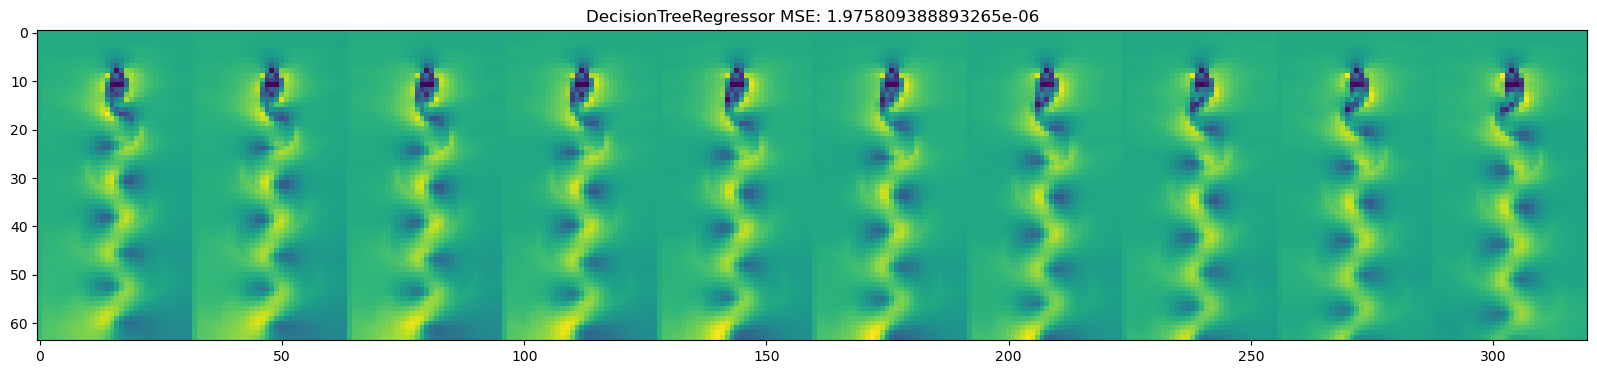

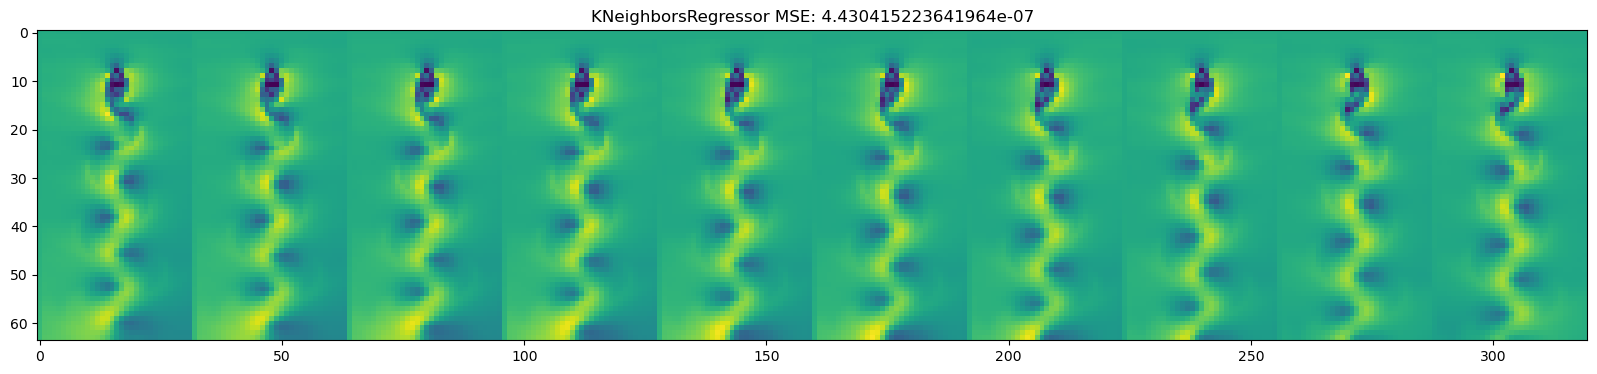

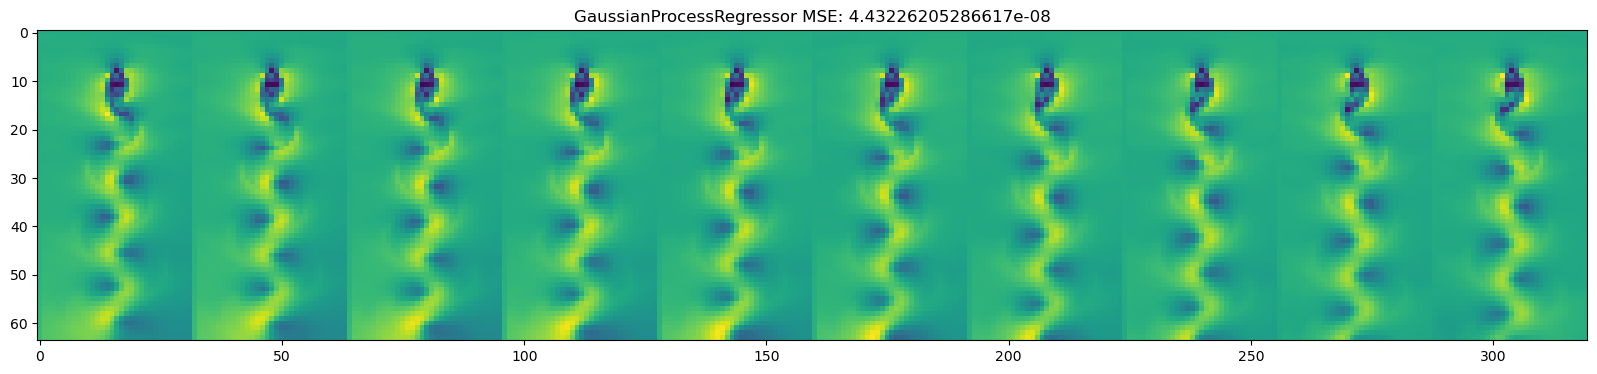

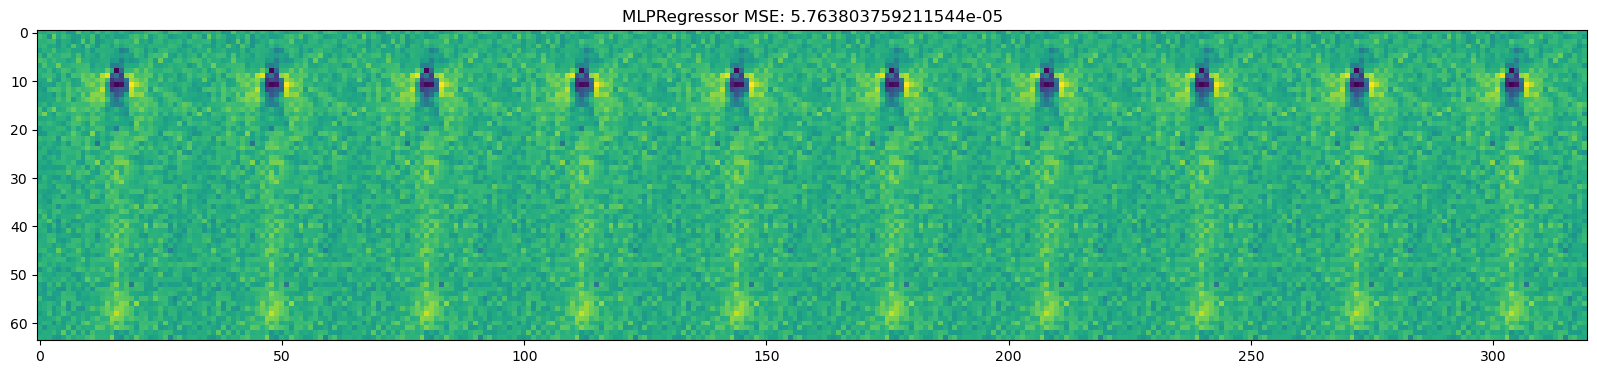

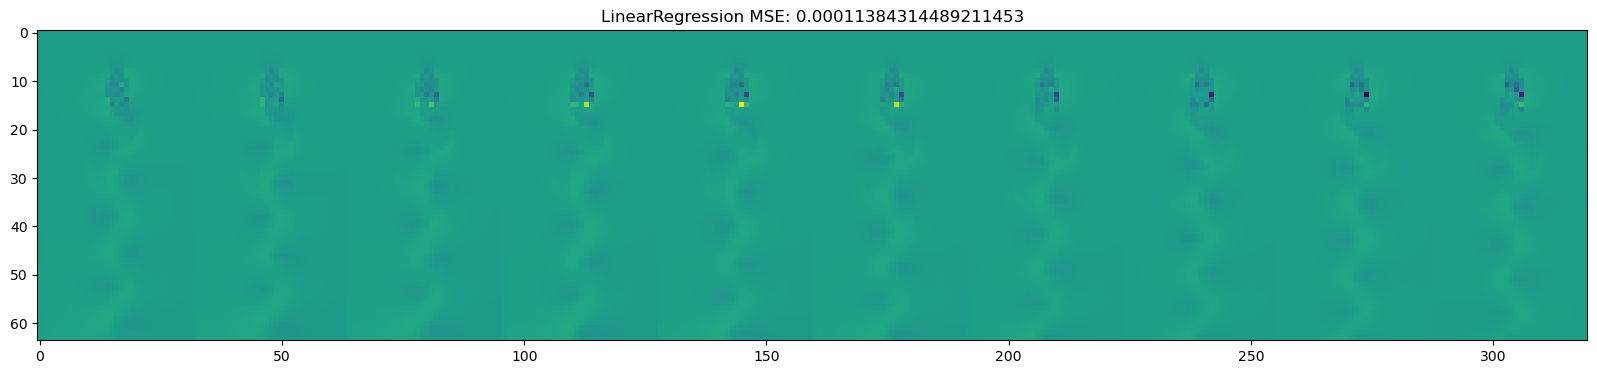

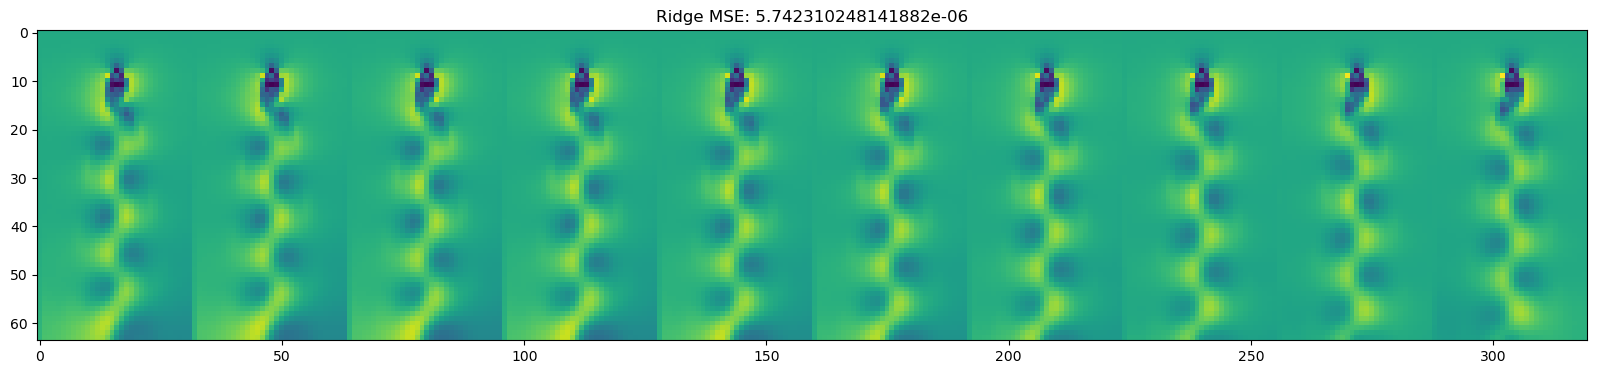

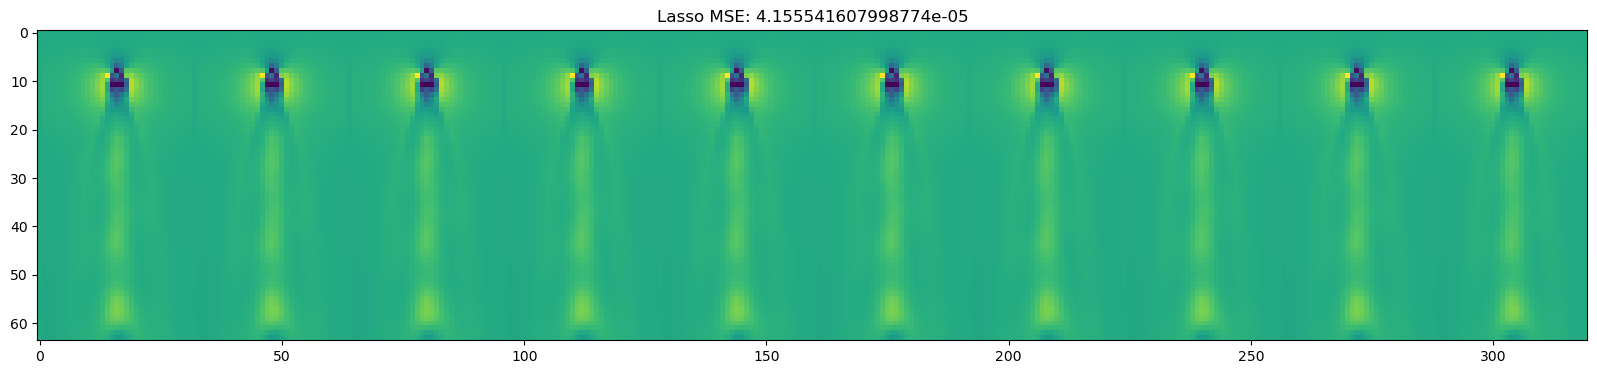

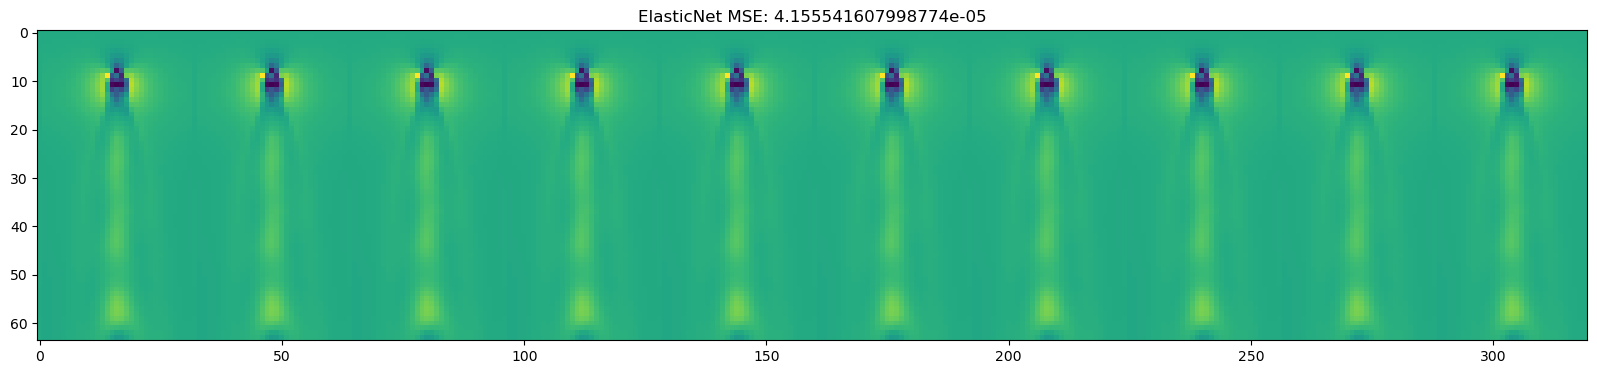

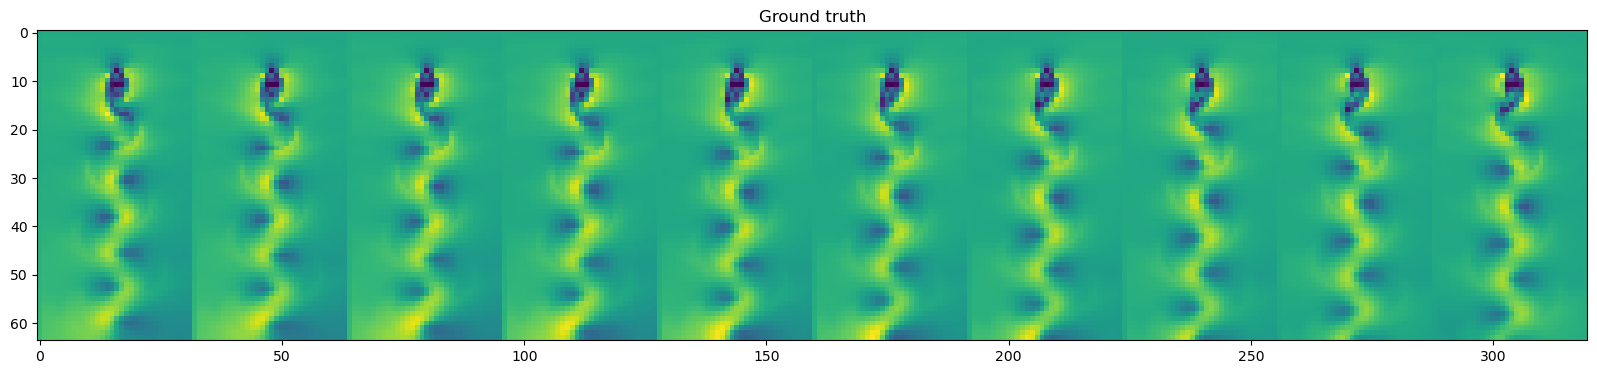

In [21]:

from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor

for model in [DecisionTreeRegressor(), KNeighborsRegressor(), 
                GaussianProcessRegressor(), MLPRegressor(), 
                LinearRegression(), Ridge(), Lasso(), ElasticNet()
            ]:

    name = type(model).__name__
    model.fit(
        dataset.flatten_data(dataset.X_train), 
        dataset.flatten_data(dataset.y_train)
    )

    y_test_pred = dataset.unflatten_data(
        model.predict(
            dataset.flatten_data(dataset.X_test)
        )
    )
    mse = np.mean((y_test_pred - dataset.y_test)**2)

    plt.figure(figsize=(20, 10))
    plt.imshow(np.hstack(y_test_pred[::3][-10:]))
    plt.title(name + " " + f"MSE: {mse}")

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(dataset.y_test[::3][-10:]))
plt.title("Ground truth")